## Applying Space-Filling Curves for Data Science with Time-Series Data on the Example of Automotive Data

Event detection is essential for various application domains. In this example, we focus on the automotive domain. We will use space-filling curves (SFCs) to reduce data dimensionality of the original data space to analyze time-series data. We will work on the compactified, single-dimensional data space to identify patterns that correlate with patterns in the multi-dimensional data space and hence, can be interpreted as events.

### 1. Introducing Space-Filling Curve Computations

To demonstrate the use of space-filling curves, we will firstly use an external library to compute single dimensional representations from multi-dimensional data called [zCurve](https://github.com/rmrschub/zCurve). The library can be used as follows:

In [1]:
import zCurve as z

# Combine the 3D point (2, 16, 8) into a Morton code.
morton_code = z.interlace(2, 16, 8)
assert morton_code == 10248, "morton_code should be 10248"
print( morton_code )

10248


Next, we focus on two-dimensional data as found in GPS positions for example. Please note that we have transformed floating point GPS positions to positive integers as SFCs typically operate on positive input values.

In [2]:
import zCurve as z

morton_code1 = z.interlace(57772400, 12765000, dims=2)
assert morton_code1 == 1606428908008832, "morton_code1 should be 1606428908008832"

morton_code2 = z.interlace(57773800, 12772000, dims=2)
assert morton_code2 == 1606429041286208, "morton_code2 should be 1606429041286208"

print( str(morton_code1) + "\n" + str(morton_code2) )

1606428908008832
1606429041286208


Next, we add a function to turn floating point numbers into positive integers using a dedicated function. The expected values originate from the [corresponding C implementation](https://github.com/chrberger/cluon-cabinet/blob/ZEBRA/test/tests-morton.cpp#L46-L84).

In [3]:
import zCurve as z

def calculateMortonFromTwoLatLonFloats_with_zCurve(x, y):
    # Cap floating point numbers to six decimal places
    x_int = int( round( (x + 90.0), 6 ) * 100000 )
    y_int = int( round( (y + 180.0), 6 ) * 100000 )
    value = z.interlace(x_int, y_int, dims=2)
    return value

morton_code1_f = calculateMortonFromTwoLatLonFloats_with_zCurve(60.734398, 14.768745)
assert morton_code1_f == 664749436223965, "morton_code1_f should be 664749436223965"
print( "Two positive floats: " + str(morton_code1_f) )

morton_code2_f = calculateMortonFromTwoLatLonFloats_with_zCurve(38.969745, -77.201958)
assert morton_code2_f == 231657429695220, "morton_code2_f should be 231657429695220"
print( "One positive/one negative float: " + str(morton_code2_f) )

morton_code3_f = calculateMortonFromTwoLatLonFloats_with_zCurve(-34.619055, -58.364067)
assert morton_code3_f == 171054631290070, "morton_code3_f should be 171054631290070"
print( "Two negative floats: " + str(morton_code3_f) )

morton_code4_f = calculateMortonFromTwoLatLonFloats_with_zCurve(-33.956603, 150.949719)
assert morton_code4_f == 769185334910863, "morton_code4_f should be 769185334910863"
print( "One negative/one positive float floats: " + str(morton_code4_f) )

Two positive floats: 664749436223965
One positive/one negative float: 231657429695220
Two negative floats: 171054631290070
One negative/one positive float floats: 769185334910863


As we want identical results on Python and C++, we supply an own implementation to calculate Morton codes from two-dimensional values. The corresponding C++ implementation can be found [here](https://github.com/chrberger/cluon-cabinet/blob/ZEBRA/src/morton.hpp#L41-L74) and the original source [here (CC BY-SA 4.0)](https://stackoverflow.com/a/30562230). Now, it is important that we are precise about the underlying dataypes and use NumPy.

In [4]:
import numpy as np

def mortonEncode2D(a, b):
    x = np.uint64(a)
    y = np.uint64(b)

    x = (x | (x << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x << np.uint64(2)))  & np.uint64(0x3333333333333333)
    x = (x | (x << np.uint64(1)))  & np.uint64(0x5555555555555555)

    y = (y | (y << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    y = (y | (y << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    y = (y | (y << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    y = (y | (y << np.uint64(2)))  & np.uint64(0x3333333333333333)
    y = (y | (y << np.uint64(1)))  & np.uint64(0x5555555555555555)

    result = np.uint64( x | (y << np.uint64(1)) )
    return result

def mortonExtractEvenBits(a):
    x = np.uint64(a)
    
    x = x & np.uint64(0x5555555555555555)
    x = (x | (x >> np.uint64(1)))  & np.uint64(0x3333333333333333)
    x = (x | (x >> np.uint64(2)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x >> np.uint64(4)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x >> np.uint64(8)))  & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x >> np.uint64(16))) & np.uint64(0x00000000FFFFFFFF)
    
    return x.astype(np.uint32)

def mortonDecode2D(a):
    _a = np.uint64(a)
    
    x = mortonExtractEvenBits(_a)
    y = mortonExtractEvenBits(_a >> np.uint64(1))
    
    return (x, y)

morton_code1 = mortonEncode2D(57772400, 12765000)
assert morton_code1 == 1606428908008832, "morton_code1 should be 1606428908008832"
print( morton_code1 )

decode_morton_code1 = mortonDecode2D(1606428908008832)
assert decode_morton_code1 == (57772400, 12765000), "decode_morton_code1 should be (57772400, 12765000)"
print( decode_morton_code1 )

1606428908008832
(57772400, 12765000)


Finally, we can compare the two implementations.

In [5]:
morton_code1_3rd = z.interlace(57772400, 12765000, dims=2)
morton_code1_own = mortonEncode2D(57772400, 12765000)

print( morton_code1_3rd - morton_code1_own )

0.0


Let's put all pieces together:

In [6]:
def calculateMortonFromTwoLatLonFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(90.0) ), 6 ) * np.uint32(100000) )
    y_int = np.uint32( np.round( (_y + np.float32(180.0) ), 6 ) * np.uint32(100000) )
    value = mortonEncode2D(x_int, y_int)
    return value

p1 = (60.734398, 14.768745)
morton_code1 = calculateMortonFromTwoLatLonFloats(p1[0], p1[1])
assert morton_code1 == 664749436224642, "morton_code1 should be 664749436224642"
print( "Two positive floats: " + str(morton_code1) )
print( "Delta to 3rd party library: " + str(morton_code1 - morton_code1_f) )

p2 = (38.969745, -77.201958)
morton_code2 = calculateMortonFromTwoLatLonFloats(p2[0], p2[1])
assert morton_code2 == 231657429695220, "morton_code2 should be 231657429695220"
print( "One positive/one negative float: " + str(morton_code2) )
print( "Delta to 3rd party library: " + str(morton_code2 - morton_code2_f) )

p3 = (-34.619055, -58.364067)
morton_code3 = calculateMortonFromTwoLatLonFloats(p3[0], p3[1])
assert morton_code3 == 171054631290070, "morton_code3 should be 171054631290070"
print( "Two negative floats: " + str(morton_code3) )
print( "Delta to 3rd party library: " + str(morton_code3 - morton_code3_f) )

p4 = (-33.956603, 150.949719)
morton_code4 = calculateMortonFromTwoLatLonFloats(p4[0], p4[1])
assert morton_code4 == 769185334910861, "morton_code4 should be 769185334910861"
print( "One negative/one positive float floats: " + str(morton_code4) )
print( "Delta to 3rd party library: " + str(morton_code4 - morton_code4_f) )

Two positive floats: 664749436224642
Delta to 3rd party library: 677.0
One positive/one negative float: 231657429695220
Delta to 3rd party library: 0.0
Two negative floats: 171054631290070
Delta to 3rd party library: 0.0
One negative/one positive float floats: 769185334910861
Delta to 3rd party library: -2.0


Finally, we convert the Morton code back into two floating point numbers.

In [7]:
def calculateTwoLatLonFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100000.0) - np.float32(90.0))
    _y = np.float32(pair[1] / np.float32(100000.0) - np.float32(180.0))
    return (_x, _y)

eps = 0.00001
decode_morton_code1 = calculateTwoLatLonFloatsFromMorton(morton_code1)
print( "{:.6f}".format(decode_morton_code1[0]) + " " + "{:.6f}".format(decode_morton_code1[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code1[0] - p1[0]) + " " + "{:.6f}".format(decode_morton_code1[1] - p1[1]))
assert np.fabs(decode_morton_code1[0] - p1[0]) < eps , "Delta for p1 after decoding too large"

decode_morton_code2 = calculateTwoLatLonFloatsFromMorton(morton_code2)
print( "{:.6f}".format(decode_morton_code2[0]) + " " + "{:.6f}".format(decode_morton_code2[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code2[0] - p2[0]) + " " + "{:.6f}".format(decode_morton_code2[1] - p2[1]))
assert np.fabs(decode_morton_code2[0] - p2[0]) < eps , "Delta for p2 after decoding too large"

decode_morton_code3 = calculateTwoLatLonFloatsFromMorton(morton_code3)
print( "{:.6f}".format(decode_morton_code3[0]) + " " + "{:.6f}".format(decode_morton_code3[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code3[0] - p3[0]) + " " + "{:.6f}".format(decode_morton_code3[1] - p3[1]))
assert np.fabs(decode_morton_code3[0] - p3[0]) < eps , "Delta for p3 after decoding too large"

decode_morton_code4 = calculateTwoLatLonFloatsFromMorton(morton_code4)
print( "{:.6f}".format(decode_morton_code4[0]) + " " + "{:.6f}".format(decode_morton_code4[1]))
print( "Delta: " + "{:.6f}".format(decode_morton_code4[0] - p4[0]) + " " + "{:.6f}".format(decode_morton_code4[1] - p4[1]))
assert np.fabs(decode_morton_code4[0] - p4[0]) < eps , "Delta for p4 after decoding too large"

60.734402 14.768730
Delta: 0.000004 -0.000015
38.969742 -77.201958
Delta: -0.000003 0.000000
-34.619061 -58.364071
Delta: -0.000006 -0.000004
-33.956612 150.949707
Delta: -0.000009 -0.000012


### 2. Processing Multi-Dimensional Automotive Data

#### 2.1 Identifying Emergency Braking Situations

Now, we have seen how to compute Morton codes from two-dimensional, floating point data including potential rounding errors that are introduced by the conversion.
In this section, we will look into how to correlate Morton codes from time-series data to a maneuver in the multi-dimensional data space. For our experiments, we will use a dataset that contains an emergency braking maneuver.
First, we analyze how the data is organized and we see that we have columns such as `lat`, `lon`, and `speed`. As a first step, we simply plot the position of the vehicle using its speed information to color its position in the scatter plot.

Column headers: ['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds', 'lat', 'lon', 'speed', 'accel_x', 'accel_y', 'accel_z']


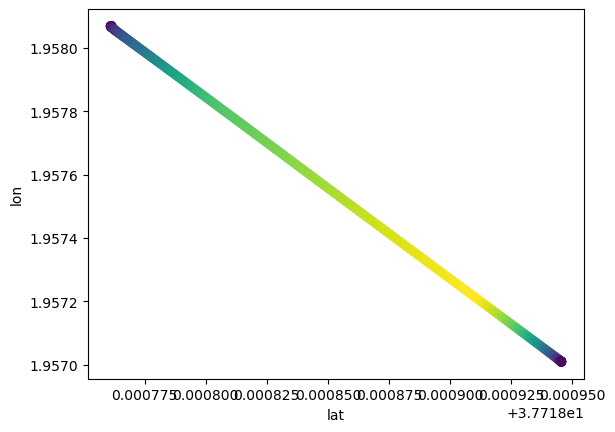

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# First, we read the CSV file.
df = pd.read_csv('emergency_braking.csv', sep=';')

# Next, we print the column headers to know what we have access to.
cols = df.columns.values.tolist()
print( "Column headers: " + str(cols) )

# Plot the position of the vehicle using its speed to color.
plt.xlabel('lat')
plt.ylabel('lon')
plt.scatter(df['lat'], df['lon'], c=df['speed'])
plt.show()

Next, we plot the various accelerations over time.

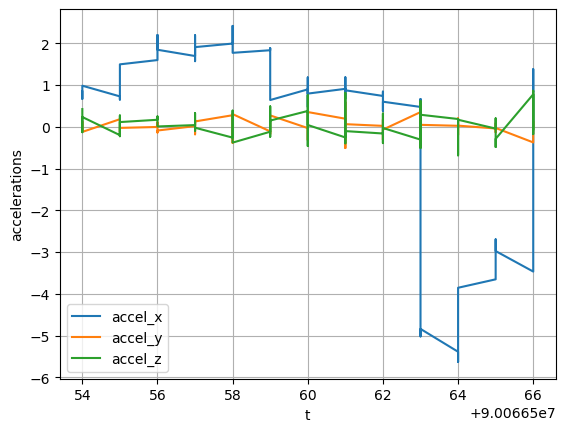

In [9]:
# Plot the accelerations.
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df['sampleTimeStamp.seconds'], df['accel_x'], label="accel_x")
plt.plot(df['sampleTimeStamp.seconds'], df['accel_y'], label="accel_y")
plt.plot(df['sampleTimeStamp.seconds'], df['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

The plots look unexpectedly _jumpy_. The reason behind it is that we chose the colum `sampleTimeStamp.seconds` that is complemented by column `sampleTimeStamp.microseconds` to reflect the actual sampling rate. Hence, we combine both columns into one new column that we name `timestamp` to reflect the correct resolution of time.

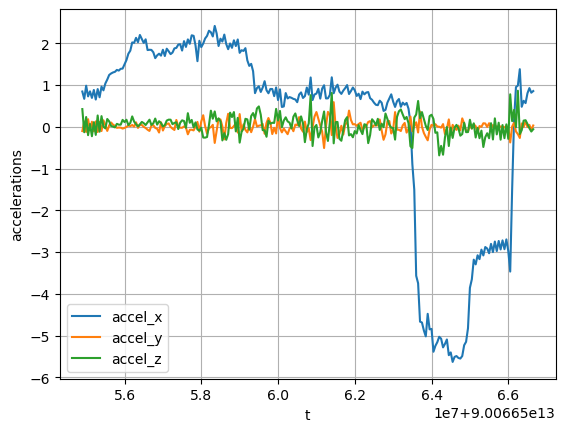

In [10]:
# Plot the accelerations but this time using the correct resolution of time.
df['timestamp'] = df['sampleTimeStamp.seconds'] * 1000000 + df['sampleTimeStamp.microseconds']
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df['timestamp'], df['accel_x'], label="accel_x")
plt.plot(df['timestamp'], df['accel_y'], label="accel_y")
plt.plot(df['timestamp'], df['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

We are interested to identify when the vehicle was starting the emergency maneuver. Intuitively, this happens when the longitudinal acceleration is starting to peak. First, we find this point in time with a naïve approach by looking at the data sample by sample and once it is exceeding a certain threshold, we assume to have found the moment when the maneuver started.

In [11]:
threshold = -5.4
times_for_maneuver = []
for _, row in df.iterrows():
    # The following line has been commented out for readability purposes.
    #print( str(row['timestamp']) + ": "+ str(row['accel_x']) )
    if row['accel_x'] < threshold:
        print( "Maneuver at " + str(row['timestamp']) )
        times_for_maneuver.append(row['timestamp'])
print( "Length of maneuver: " + str(len(times_for_maneuver)) )

Maneuver at 90066564446148.0
Maneuver at 90066564495895.0
Maneuver at 90066564545893.0
Maneuver at 90066564595904.0
Maneuver at 90066564645871.0
Maneuver at 90066564695876.0
Maneuver at 90066564745892.0
Maneuver at 90066564795926.0
Length of maneuver: 8


For emergency braking, the maneuver can be easily identified by sorting all data by longitudinal accelerations as key pointing to the respective timepoints. However, this approach would only work as long as we only use one dimension from a multi-dimensional dataspace. Once we use more dimensions, we need a different strategy and here, the concept of space-filling curves is useful.

Using our previous approach, the maneuver was found as expected but for an expensive computational operation: `O(n)`. In particular, this is a disadvantage in case the problem size grows, ie., when more data would need to be processed. In addition, when we fine-tune the threshold, we would have to re-run the detector again for the same computational effort. So, we are interested to find a better approach that is ideally agnostic from the amount of data but is similar to our intuitive approach when we "just looked" at the peaks of the data.

The problem, though, is that we want to analyze time-series data, which can be arbitrarily large and that we may need to analyze multiple dimensions simultaneously. Now, space-filling curves come into play when we try a better approach to spot interesting events in time-series data. When analyzing time-series data using the ordering criterion time for queries, data look-ups are simple and fast for queries such as: "How did the data sample look like at time X?" or "How many data samples do we have between time points X and Y?".

Yet, such queries are usually less relevant for data analysts who are interested in certain properties or conditions taking place in the multi-dimensional data space, where, however, the look-up is computationally expensive for growing amounts of data. Hence, we are interested in a computationally efficient approach to process multi-dimensional data samples.

Now, we are exploiting space-filling curves for this purpose to encode multi-dimensional data samples in a way that allows us to conduct a quick look-up of _relevant_ data.

Firstly, we define conversion functions to map two-dimensional data like longitudinal and lateral accelerations into single-dimensional Morton values including the corresponding inverse operations:

In [12]:
def calculateMortonFromXYAccelerationFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(10.0) ), 6 ) * np.uint32(100) )
    y_int = np.uint32( np.round( (_y + np.float32(10.0) ), 6 ) * np.uint32(100) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateXYAccelerationFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100.0) - np.float32(10.0))
    _y = np.float32(pair[1] / np.float32(100.0) - np.float32(10.0))
    return (_x, _y)

As we noticed that the emergency braking manifests clearly along the longitudinal acceleration, we define the consant `y = 0`:

In [13]:
counter = 0
y = 0
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], y)
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + ",0) --> " + str(morton) )
    counter = counter + 1
print( "Processed " + str(counter) + " rows." )

90066554895574.0: (0.844492,0) --> 1748432
90066554945599.0: (0.668745,0) --> 1748164
90066554995606.0: (0.983568,0) --> 1751236
90066555045596.0: (0.72774,0) --> 1748352
90066555095560.0: (0.848665,0) --> 1748432
90066555145602.0: (0.691178,0) --> 1748177
90066555195612.0: (0.881787,0) --> 1751168
90066555245543.0: (0.651897,0) --> 1748161
90066555295612.0: (0.903434,0) --> 1751172
90066555345551.0: (0.705729,0) --> 1748180
90066555395565.0: (0.961155,0) --> 1751232
90066555445902.0: (0.872531,0) --> 1748437
90066555495627.0: (1.03666,0) --> 1751253
90066555545615.0: (1.13085,0) --> 1751489
90066555595574.0: (1.24108,0) --> 1752208
90066555645582.0: (1.27647,0) --> 1752213
90066555695577.0: (1.30093,0) --> 1752260
90066555745609.0: (1.31599,0) --> 1752261
90066555795654.0: (1.36157,0) --> 1752448
90066555845572.0: (1.3456,0) --> 1752276
90066555895608.0: (1.38821,0) --> 1752452
90066555945581.0: (1.39364,0) --> 1752453
90066555995630.0: (1.49496,0) --> 1752529
90066556045571.0: (1.597

Simply calcuating the Morton codes for the given tuples for floating point values is pointless unless we store the data in a new tabluar representation. In the following, we compute the Morton codes for the accelerations in X/Y directions to obtain a single-dimensional representation of the data values.

In [14]:
lst = []
y = 0
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], y)
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df2 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df2 )

      morton     timestamp
0    1748432  9.006655e+13
1    1748164  9.006655e+13
2    1751236  9.006655e+13
3    1748352  9.006656e+13
4    1748432  9.006656e+13
..       ...           ...
231  1748096  9.006657e+13
232  1748416  9.006657e+13
233  1751184  9.006657e+13
234  1748417  9.006657e+13
235  1748433  9.006657e+13

[236 rows x 2 columns]


Let's look at the data how it is stored in the new table. As we deal with single-dimensional data, we use a stripe plot for clarity.

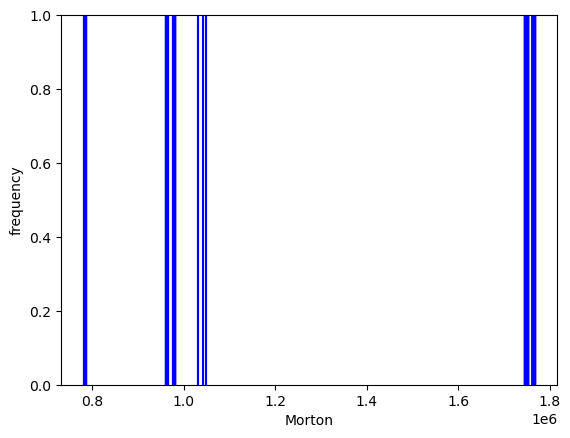

In [15]:
from matplotlib import pyplot as plt

data = df2['morton']
plt.figure()
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors='b', lineoffsets=0.5)
plt.show()

So, the question is how to interpret the new data that we generated using the Morton computations. Let's iterate over all new rows to split the tuples `(Morton value, timestamp)` such that those Morton values, which do not belong to the time points when the vehicle exhibited an emergency braking maneuver (that we calculated already before using a computationally expensive approach), are in one group (`group_A`) and the others in another group (`group_B`). Then, we can color both groups differently for clarity in the plot. 

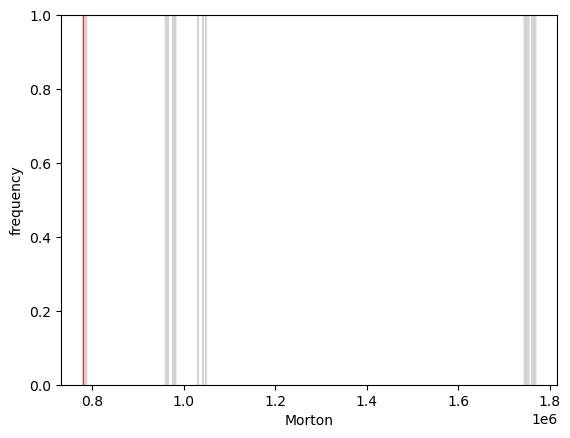

In [16]:
group_A = []
group_B = []
for _, row in df2.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver:
        group_A.append(morton)
    else:
        group_B.append(morton)

data = [group_A, group_B]
data_colors = ['red', 'lightgray']

plt.figure()
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
plt.show()

It seems that the emergency braking maneuver of interest is gathering in a certain spectrum of our single-dimensional representation; let's zoom in:

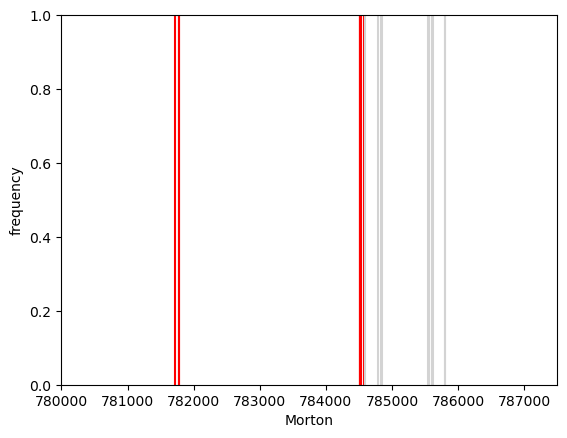

In [17]:
group_A = []
group_B = []
for _, row in df2.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver:
        group_A.append(morton)
    else:
        group_B.append(morton)

data = [group_A, group_B]
data_colors = ['red', 'lightgray']

plt.figure()
plt.xlabel('Morton')
plt.ylabel('frequency')
# Zoom in around 0.78e6.
plt.xlim( (0.78e6,0.7875e6) )
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
plt.show()

After zooming in, it looks like as if a simply threshold query would help to spot the emergency braking maneuver. Hence, we can exploit this accumulation when we sort our tabular representation of tuples `(Morton value, timestamp)` by increasing Morton values:

In [18]:
df2 = df2.sort_values(by=['morton'])
print( df2 )

      morton     timestamp
193   781713  9.006656e+13
197   781777  9.006656e+13
196   781780  9.006656e+13
194   784513  9.006656e+13
198   784517  9.006656e+13
..       ...           ...
74   1767568  9.006656e+13
70   1767573  9.006656e+13
67   1767620  9.006656e+13
66   1767633  9.006656e+13
69   1767873  9.006656e+13

[236 rows x 2 columns]


Now, we can exploit our knowledge that the emergency braking maneuver accumulates around the Morton values lower than `0.78459e6` and hence, we can simply filter by keys within this range:

In [19]:
dict_of_morton_to_timestamps = dict(zip(df2.morton, df2.timestamp))
matches = list(filter( lambda k: k < 0.78459e6, dict_of_morton_to_timestamps.keys()) )
print( "Length of maneuver: " + str(len(matches)) + ", entries: " + str(matches))

Length of maneuver: 7, entries: [781713, 781777, 781780, 784513, 784517, 784529, 784581]


Please note that we have 7 entries even though the length of the maneuver was identified as 8 using the brute-force approach before. The reason is that the Morton value `784517` has been assigned twice but is only listed once in the list.

In [20]:
from collections import defaultdict
from itertools import chain

# The standard dictionary in Python does not allow duplicated keys and hence, we use the defaultdict based on list.
defaultdict_of_morton_to_timestamps = defaultdict(list)
for k, v in zip(df2.morton, df2.timestamp):
    defaultdict_of_morton_to_timestamps[k].append(v)

# Filter the keys between the lower and upper limit.
matches = list(filter( lambda k: k < 0.78459e6, defaultdict_of_morton_to_timestamps.keys()) )

# Finally, we need to "flatten" the matches to reduce the set of duplicated values for some keys:
_timepoints = []
for e in matches:
    _timepoints.append(defaultdict_of_morton_to_timestamps[e])
timepoints_for_maneuver_morton_setting_y_to_0 = sorted(list(chain.from_iterable(_timepoints)))
print( "Length of maneuver: " + str(len(timepoints_for_maneuver_morton_setting_y_to_0)) + ", entries: " + str(timepoints_for_maneuver_morton_setting_y_to_0))

Length of maneuver: 8, entries: [90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]


Now, the number of values matches the ones from the brute-force approach. Let's check whether the lists are identical:

In [21]:
print( str(times_for_maneuver) )
print( str(timepoints_for_maneuver_morton_setting_y_to_0) )

if times_for_maneuver == timepoints_for_maneuver_morton_setting_y_to_0:
    print("The lists are identical.")
else:
    print("The lists are not identical.")

[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
The lists are identical.


So far, we have demonstrated how to use Morton values for a single dimension while using a constant for the other dimension, ie., `y = 0`.

Now, we use both, the real lateral and longitudinal accelerations.

In [22]:
counter = 0
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + "," + str(row['accel_y']) + ") --> " + str(morton) )
    counter = counter + 1
print( "Processed " + str(counter) + " rows." )

90066554895574.0: (0.844492,-0.10224) --> 1746930
90066554945599.0: (0.668745,0.12584) --> 1748580
90066554995606.0: (0.983568,-0.123143) --> 1749710
90066555045596.0: (0.72774,0.181749) --> 1748872
90066555095560.0: (0.848665,-0.0734866) --> 1748304
90066555145602.0: (0.691178,0.121459) --> 1748593
90066555195612.0: (0.881787,-0.106376) --> 1749666
90066555245543.0: (0.651897,0.128891) --> 1748577
90066555295612.0: (0.903434,-0.125764) --> 1749646
90066555345551.0: (0.705729,0.115673) --> 1748574
90066555395565.0: (0.961155,-0.102459) --> 1749730
90066555445902.0: (0.872531,0.154934) --> 1748863
90066555495627.0: (1.03666,0.0371734) --> 1751263
90066555545615.0: (1.13085,-0.0987154) --> 1749993
90066555595574.0: (1.24108,0.0332524) --> 1752218
90066555645582.0: (1.27647,0.102615) --> 1752605
90066555695577.0: (1.30093,0.0503731) --> 1752294
90066555745609.0: (1.31599,0.0225835) --> 1752269
90066555795654.0: (1.36157,-0.0245219) --> 1752354
90066555845572.0: (1.3456,-0.0180335) --> 175

Let's create a tabular representation again:

In [23]:
lst = []
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_x'], row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df2 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df2 )

      morton     timestamp
0    1746930  9.006655e+13
1    1748580  9.006655e+13
2    1749710  9.006655e+13
3    1748872  9.006656e+13
4    1748304  9.006656e+13
..       ...           ...
231  1748512  9.006657e+13
232  1748330  9.006657e+13
233  1751216  9.006657e+13
234  1748291  9.006657e+13
235  1748443  9.006657e+13

[236 rows x 2 columns]


Let's look at the data how it is stored in the new table. As we deal with single-dimensional data, we use a stripe plot for clarity.

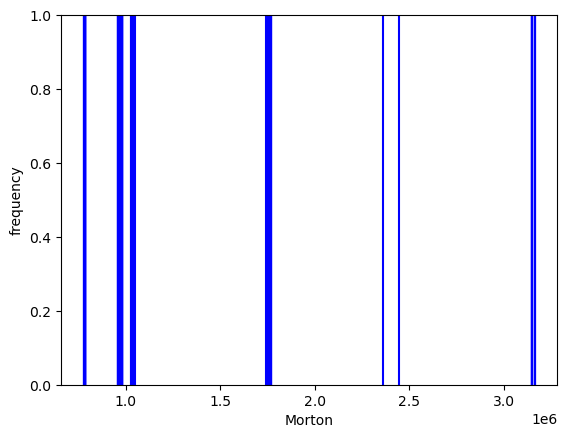

In [24]:
from matplotlib import pyplot as plt

data = df2['morton']

plt.figure()
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors='b', lineoffsets=0.5)
plt.show()

So, the question is how to interpret the new data that we generated using the Morton computations. Let's iterate over all new rows to split the tuples `(Morton value, timestamp)` such that those Morton values, which do not belong to the time points when the vehicle exhibited an emergency braking maneuver (that we calculated already before using a computationally expensive approach), are in one group (`group_A`) and the others in another group (`group_B`). Then, we can color both groups differently for clarity in the plot. 

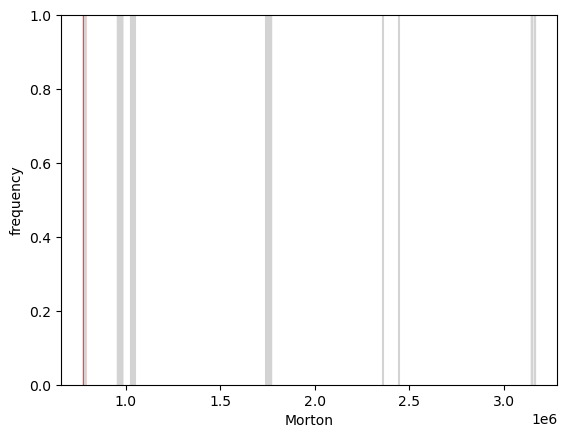

In [25]:
group_A = []
group_B = []
for _, row in df2.iterrows():
    morton = row['morton']
    timestamp = row['timestamp']
    if timestamp in times_for_maneuver:
        group_A.append(morton)
    else:
        group_B.append(morton)

data = [group_A, group_B]
data_colors = ['red', 'lightgray']

plt.figure()
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
plt.show()

It seems that the emergency braking maneuver of interest is gathering in a certain spectrum of our single-dimensional representation; and actually, we can exploit this accumulation when we sort our tabular representation of tuples `(Morton value, timestamp)` by increasing Morton values:

In [26]:
df2 = df2.sort_values(by=['morton'])
print( df2 )

      morton     timestamp
197   780283  9.006656e+13
193   781745  9.006656e+13
196   781788  9.006656e+13
192   782949  9.006656e+13
179   783790  9.006656e+13
..       ...           ...
139  3147196  9.006656e+13
131  3149128  9.006656e+13
82   3162473  9.006656e+13
76   3163179  9.006656e+13
63   3163231  9.006656e+13

[236 rows x 2 columns]


Now, we can exploit our knowledge from before that the emergency braking maneuver accumulates around the Morton values below `0.78459e6` and hence, we can simply filter by keys within this range:

In [27]:
dict_of_morton_to_timestamps = dict(zip(df2.morton, df2.timestamp))
matches = list(filter( lambda k: k < 0.78459e6, dict_of_morton_to_timestamps.keys()) )
print( "Length of maneuver: " + str(len(matches)) + ", entries: " + str(matches))

Length of maneuver: 9, entries: [780283, 781745, 781788, 782949, 783790, 783912, 784057, 784389, 784419]


Using the same lower and upper limits for the range to match the keys as for the previous case when we used a constant for y does not yield the same results. This is understandable as the Morton values differ because their are computed based on two dimensions and hence, we need to relax the range filter. Therefore, we use a larger area: 0.785e6:

In [28]:
dict_of_morton_to_timestamps = dict(zip(df2.morton, df2.timestamp))
matches = list(filter( lambda k: k < 0.8e6, dict_of_morton_to_timestamps.keys()) )
print( "Length of maneuver: " + str(len(matches)) + ", entries: " + str(matches))

Length of maneuver: 19, entries: [780283, 781745, 781788, 782949, 783790, 783912, 784057, 784389, 784419, 784601, 784829, 784877, 784891, 785043, 785061, 785508, 785522, 785552, 785793]


Now, we received those Morton codes that are between the specified minimum and maximum values but the list is longer than the one we got based on the brute-force detector. Let's decode the Morton values to compare the encoded accelerations:

In [29]:
for morton in matches:
    acc = calculateXYAccelerationFloatsFromMorton(morton)
    print( str(morton) + " --> " + "(" + str(acc[0]) + "," + str(acc[1]) + ")")

780283 --> (-5.55,-0.09)
781745 --> (-5.63,0.04)
781788 --> (-5.54,0.02)
782949 --> (-5.41,-0.2)
783790 --> (-5.02,-0.25)
783912 --> (-5.2,-0.18)
784057 --> (-5.15,-0.1)
784389 --> (-5.49,-0.08)
784419 --> (-5.51,-0.03)
784601 --> (-5.39,0.02)
784829 --> (-5.29,0.06)
784877 --> (-5.25,0.06)
784891 --> (-5.23,0.07)
785043 --> (-5.47,0.17)
785061 --> (-5.49,0.2)
785508 --> (-5.1,-0.04)
785522 --> (-5.08,-0.03)
785552 --> (-5.16,0.0)
785793 --> (-5.03,0.0)


As we can see, there are a few Morton values that are above the threshold of `-5.4` that we defined above. Next, we match the Morton values that act as keys in our dictionary `dict_of_morton_to_timestamps` with the list of `times_for_maneuver` from the brute-force approach to validate that we actually found the correct elements for the one with the correct accelerations:

In [30]:
times_for_maneuver_morton = []
for morton in matches:
    acc = calculateXYAccelerationFloatsFromMorton(morton)
    if acc[0] < threshold:
        times_for_maneuver_morton.append(dict_of_morton_to_timestamps[morton])
times_for_maneuver.sort()
times_for_maneuver_morton.sort()

print( str(times_for_maneuver) )
print( str(times_for_maneuver_morton) )

if times_for_maneuver == times_for_maneuver_morton:
    print("The lists are identical.")
else:
    print("The lists are not identical.")

[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
[90066564446148.0, 90066564495895.0, 90066564545893.0, 90066564595904.0, 90066564645871.0, 90066564695876.0, 90066564745892.0, 90066564795926.0]
The lists are identical.


Let's compare the computational performance for both event detectors, starting with the previous one that is operating on the multi-dimensional data space (the print statements have been disabled):

In [31]:
%%timeit
threshold = 5.4
times_for_maneuver = []
for _, row in df.iterrows():
    #print( str(row['timestamp']) + ": "+ str(row['accel_x']) )
    if row['accel_x'] < threshold:
        #print( "Maneuver at " + str(row['timestamp']) )
        times_for_maneuver.append(row['timestamp'])

2.69 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now, let's time the key ranges look-up (the print statement has been disabled):

In [32]:
%%timeit
my_dict = dict(zip(df2.morton, df2.timestamp))
l = list(filter( lambda k: k < 0.8e6, my_dict.keys()) )
#print(str(l))

39.4 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The dict-based key look-up using a range filter is much faster than the `O(n)` event look-up.

Finally, we need to check whether our key-based range look-up does not react when there is no emergency braking maneuver, ie., no peak in the data. Therefore, we simpy replace `accel_x` with `accel_z` and repeat the analysis.

      morton     timestamp
0    1745830  9.006655e+13
1    1047396  9.006655e+13
2    1046495  9.006655e+13
3    1047437  9.006656e+13
4    1047636  9.006656e+13
..       ...           ...
231  1048373  9.006657e+13
232  1047678  9.006657e+13
233  1047728  9.006657e+13
234  1046866  9.006657e+13
235  1047694  9.006657e+13

[236 rows x 2 columns]


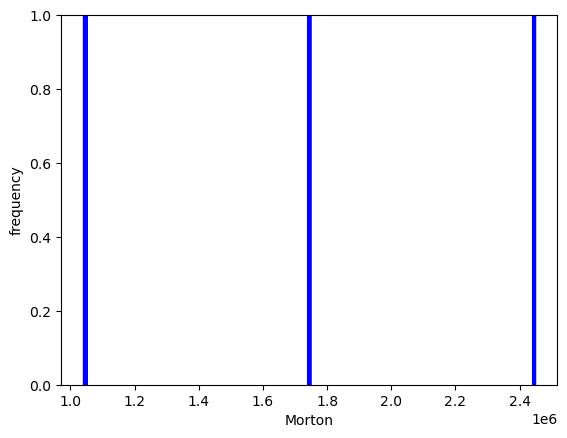

In [33]:
lst = []
for _, row in df.iterrows():
    morton = calculateMortonFromXYAccelerationFloats(row['accel_z'], row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

df3 = pd.DataFrame(lst, columns=['morton', 'timestamp'])
print( df3 )

data = df3['morton']

plt.figure()
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim( (0,1) )
plt.eventplot(data, orientation='horizontal', colors='b', lineoffsets=0.5)
plt.show()

And indeed, the stripes around 0.75e6 disappeared as expected.

#### 2.2 Identifying Lane-Change Situations

We saw how to spot emergency braking situations in time-series of accelerations by using Morton values generated by a space-filling curve.

Next, we want to search for situations when a vehicle was changing lanes. Therefore, we are using a different dataset that contains a situation where a lane-change took place. Hence, let's plot the data again.

Column headers: ['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds', 'lat', 'lon', 'speed', 'accel_x', 'accel_y', 'accel_z']


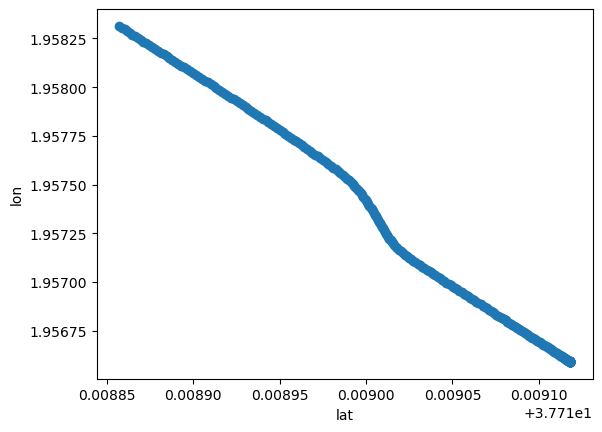

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# First, we read the CSV file.
df_lane_change = pd.read_csv('lane_change.csv', sep=';')

# Next, we print the column headers to know what we have access to.
cols = df_lane_change.columns.values.tolist()
print( "Column headers: " + str(cols) )

# Plot the position of the vehicle using its speed to color.
plt.figure()
plt.xlabel('lat')
plt.ylabel('lon')
plt.scatter(df_lane_change['lat'], df_lane_change['lon'])
plt.show()

Next, we plot the accelerations as before after correcting the timestamps (ie., combining the two separate fields `seconds` and `microseconds` into one new field called `timestamp`). 

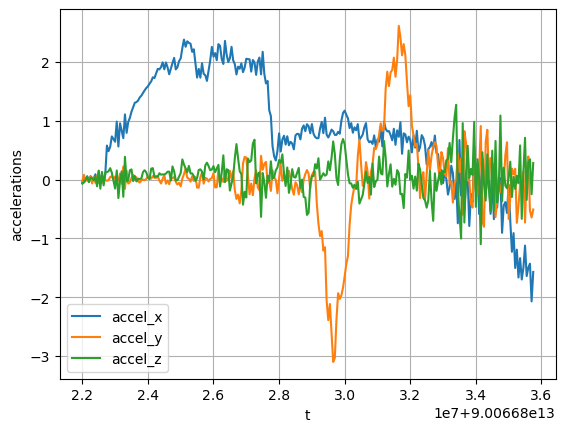

In [35]:
# Plot the accelerations but this time using the correct resolution of time.
df_lane_change['timestamp'] = df_lane_change['sampleTimeStamp.seconds'] * 1000000 + df_lane_change['sampleTimeStamp.microseconds']

plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In the previous plot, we can clearly see that the vehicle was accelerating first (blue line) before the lane change took place (orange line).

What we can see is that the actual lane change consists out of three parts highlighted with three rectangles: A lower part where the vehicle's negative acceleration is below a certain threshold, followed by the vehicle's acceleration crossing the "zero-line" (ie., `y = 0`), followed by the vehicle's lateral acceleration residing above a certain threshold. The following plot is illustrating these parts using three rectangles: a blue, a black, and a red one, respectively.  

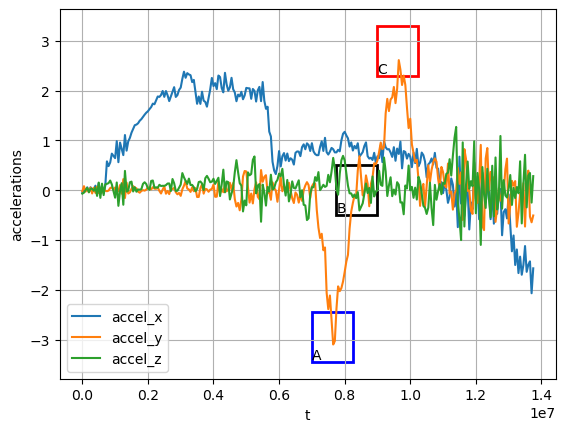

In [36]:
import matplotlib.patches as patches

# Plot the accelerations but this time using the correct resolution of time and subtract by the first value to let the X values start at 0.
offset = df_lane_change['sampleTimeStamp.seconds'][0] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'][0]
df_lane_change['timestamp'] = df_lane_change['sampleTimeStamp.seconds'] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'] - offset

plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)

# Add illustrating rectangles around the areas of interest.
plt.text(0.7*1e7, -3.4, 'A')
lower = patches.Rectangle( (0.7*1e7, -3.45), 1.25e6, 1, linewidth=2, edgecolor="blue", facecolor='none')

plt.text(0.775*1e7, -.45, 'B')
middle = patches.Rectangle( (0.775*1e7, -.5), 1.25e6, 1, linewidth=2, edgecolor="black", facecolor='none')

plt.text(0.9*1e7, 2.35, 'C')
upper = patches.Rectangle( (0.9*1e7, 2.3), 1.25e6, 1, linewidth=2, edgecolor="red", facecolor='none')

plt.gca().add_patch(upper)
plt.gca().add_patch(middle)
plt.gca().add_patch(lower)

plt.show()

We can see that we can expect one peak above $-2\frac{m}{s^2}$ between $t_1$ and $t_2$, followed by $0\frac{m}{s^2}$ between $t_3$ and $t_4$, and finally a peak for $+2\frac{m}{s^2}$ between $t_5$ and $t_6$.

We demand:

$\text{R1: } t_1 < t_2 < t_3 < t_4 < t_5 < t_6$,

and:

$\text{RA: } (t_2 - t_1) \in [\text{lower}_{\text{min}}, \text{lower}_{\text{max}}]$

$\text{RB: } (t_4 - t_3) \in [\text{middle}_{\text{min}}, \text{middle}_{\text{max}}]$

$\text{RC: } (t_6 - t_5) \in [\text{upper}_{\text{min}}, \text{upper}_{\text{max}}]$

and:

$\text{R2: } (t_6 - t_1) \in [\text{event}_{\text{min}}, \text{event}_{\text{max}}]$

However, as long as the conditions $t_2 < t_5$ and $\text{lower}_\text{max} < \text{upper}_\text{min}$ are fulfilled, we can skip the black box in the middle as physically, the vehicle's lateral acceleration must cross the "zero-line" to reach from the lower box (A) the upper box (C). Hence, we skip the middle box in the filtering to simplify the algorithm by exploiting this observation.

Next, we calculate the Morton values and restrict us to calculate them only for the lateral acceleraton. Then, we try to intuitively overlay them with the plot so we can easily identify the Morton value ranges that we are interested in. Please note that this intuitive overlay is for illustrative purpose only.

In [37]:
counter = 0

lst = []
lst_morton_points = []
longitudinal_acceleration = 0.0
for _, row in df_lane_change.iterrows():
    # Compute the Morton value but keep the longitudinal acceleration const to 0.0
    morton = calculateMortonFromXYAccelerationFloats(longitudinal_acceleration, row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

    # Scale the Morton values so that we can create an intuitive overlay plot.
    lst_morton_points.append({'timestamp': row['timestamp'], 'morton': (morton-2.1e6)/1e6})
    
    # Print raw Morton values.
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + "," + str(row['accel_y']) + ") --> " + str(morton) )
    counter = counter + 1

df_lane_change_morton = pd.DataFrame(lst, columns=['morton', 'timestamp'])

df_lane_change_morton_scaled = pd.DataFrame(lst_morton_points, columns=['morton', 'timestamp'])
print( df_lane_change_morton_scaled )

print( "Processed " + str(counter) + " rows." )

0.0: (-0.0520667,-0.0213955) --> 1047650
49981.0: (0.0388273,0.0807152) --> 1048128
99966.0: (0.00042123,-0.028714) --> 1047650
149971.0: (0.0570567,0.0330966) --> 1047754
199986.0: (-0.0299872,-0.0405175) --> 1047626
249957.0: (0.0578943,0.0528362) --> 1047778
299946.0: (0.0210833,-0.0662587) --> 1047618
349981.0: (0.0174745,0.0491748) --> 1047776
399964.0: (0.0908629,-0.0552473) --> 1047624
450259.0: (-0.057315,0.0710498) --> 1047786
499993.0: (0.142732,-0.0586542) --> 1047624
549962.0: (-0.0735975,0.0354081) --> 1047754
599957.0: (0.08656,-0.0439573) --> 1047626
649957.0: (-0.0610962,0.0119785) --> 1047746
699956.0: (0.0919961,-0.00969661) --> 1047658
749982.0: (0.579202,-0.0207705) --> 1047650
800021.0: (0.48389,-0.00807144) --> 1047658
849951.0: (0.556501,0.0433084) --> 1047776
899973.0: (0.734354,0.057492) --> 1047778
949949.0: (0.689343,0.00300318) --> 1047744
1000036.0: (0.643961,0.0538019) --> 1047778
1049998.0: (0.985848,-0.0191281) --> 1047656
1100026.0: (0.562318,-0.0193858

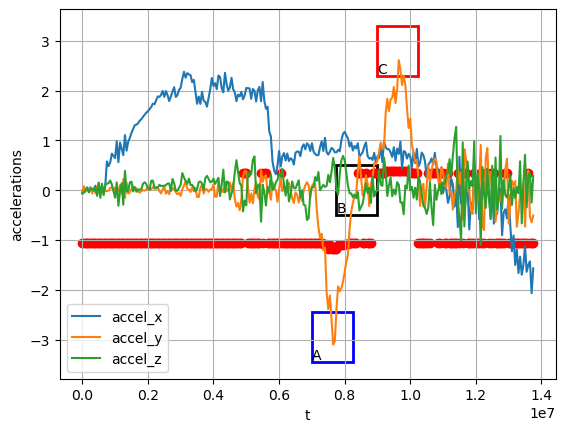

In [38]:
# Plot the accelerations but this time using the correct resolution of time and subtract by the first value to let the X values start at 0.
offset = df_lane_change['sampleTimeStamp.seconds'][0] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'][0]
df_lane_change['timestamp'] = df_lane_change['sampleTimeStamp.seconds'] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'] - offset

plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)

# Add illustrating rectangles around the areas of interest.
plt.text(0.7*1e7, -3.4, 'A')
lower = patches.Rectangle( (0.7*1e7, -3.45), 1.25e6, 1, linewidth=2, edgecolor="blue", facecolor='none')

plt.text(0.775*1e7, -.45, 'B')
middle = patches.Rectangle( (0.775*1e7, -.5), 1.25e6, 1, linewidth=2, edgecolor="black", facecolor='none')

plt.text(0.9*1e7, 2.35, 'C')
upper = patches.Rectangle( (0.9*1e7, 2.3), 1.25e6, 1, linewidth=2, edgecolor="red", facecolor='none')

plt.gca().add_patch(upper)
plt.gca().add_patch(middle)
plt.gca().add_patch(lower)

# Add the "kind of intuitive" overlay of the scaled Morton values. 
plt.scatter(df_lane_change_morton_scaled['timestamp'], df_lane_change_morton_scaled['morton'], color='red')

plt.show()

We can see that the Morton values show a "tendency" to point towards the peaks that we are interested in.

The blue rectangle `A` is denoting Morton values $v$ in the proximity of $910000$.

The red rectangle `C` is denoting Morton values $v$ that reach around $2488000$ or more.

With this information, we can query a table that is using the Morton values as keys to values comprising of the actual timestamps of interest.

In [39]:
my_dict = dict(zip(df_lane_change_morton.morton, df_lane_change_morton.timestamp))

area_a = list(filter( lambda k: k > 8.9e5 and k < 9.1e5, my_dict.keys()) )
print( "Area A: " + str(area_a))

area_c = list(filter( lambda k: k > 2.488e6 and k < 2.6e6, my_dict.keys()) )
print( "Area C: " + str(area_c))

Area A: [908872, 908992]
Area C: [2489570, 2488008]


Now, we need to match the temporal constraints, ie., the identified elements from `area_a` must fulfill the constraint of being of a _reasonable_ minimum length but not exceeding a _maximum_ length. Therefore, we start at the first element of the list for `area_a` and continue adding more elements as long as we are not exceeding the _maximum_ length. The following code is computing all possible matching temporal ranges for the areas A, B, and C to fulfill the requirements RA, RB, and RC as mentioned before:

In [40]:
# Turn list of Morton codes back to time points:
time_points_area_a = []
time_points_area_c = []

for a in area_a:
    time_points_area_a.append(my_dict[a])
for c in area_c:
    time_points_area_c.append(my_dict[c])

# Sort by time.
time_points_area_a = sorted( time_points_area_a )
time_points_area_c = sorted( time_points_area_c )

# Heuristically determined; given in µs.
minimum_duration =  40000
maximum_duration = 200000

# This function returns a list of tuples (a, b) where (b-a) is the largest range within [minimum_duration, maximum_duration] from a list of timepoints:
def getRanges(listOfTimePoints, minDuration, maxDuration):
    assert len(listOfTimePoints) > 1, "listOfTimePoints must contain minimally two items"
    listOfTuples = []

    lastIdx = 0
    # Once a tuple has been added to the list of matching temporal ranges, start *after* the end point of the last tuple as long as there is more to process.
    while lastIdx < len(listOfTimePoints) and ((len(listOfTimePoints) - lastIdx) > 1):
        idx = lastIdx
        t1 = 0
        t2 = 0

        # Skip all time points that have been processed so far already (ie., slicing from idx:).
        for t in listOfTimePoints[idx:]:
            idx = idx + 1
            if t1 == 0:
                t1 = t
                continue
            # Check whether we find matching durations:
            if (t - t1) > minimum_duration and (t - t1) < maximum_duration:
                t2 = t
            # Stop criterion once we exceed the maximum duration:
            if (t - t1) > maximum_duration:
                break
        # Only add a tuple when we have valid start and end time points:
        if t1 > 0 and t2 > 0:
            listOfTuples.append( (t1, t2) )
            print( "Range " + str(len(listOfTuples)) + ": " + str(t1) + " --> " + str(t2) )
        lastIdx = idx
    return listOfTuples

ranges_a = getRanges(time_points_area_a, minimum_duration, maximum_duration)
print(str(ranges_a))

ranges_c = getRanges(time_points_area_c, minimum_duration, maximum_duration)
print(str(ranges_c))

Range 1: 7650208.0 --> 7700191.0
[(7650208.0, 7700191.0)]
Range 1: 9650266.0 --> 9700278.0
[(9650266.0, 9700278.0)]


Next, we need to traverse the three lists to fulfill requirements R1 and R2:

In [41]:
# Heuristically determined; given in µs.
minimum_event_duration = 2000000
maximum_event_duration = 5000000

# Starting from the first list, we add elements from the other lists as long as R1 and R2 are fulfilled:
listOfEvents = []
for a in ranges_a:
    for c in ranges_c:
        # Check for t2 < t5
        if a[1] > c[0]:
            continue
        if ((c[1] - a[0]) > minimum_event_duration) and ((c[1] - a[0]) < maximum_event_duration):
            listOfEvents.append( (a, c) )
print( str(listOfEvents) )

[((7650208.0, 7700191.0), (9650266.0, 9700278.0))]


Next, let's plot the resulting ranges as overlay to our plot. Therefore, we query the timepoints in a dictionary to get the corresponding accelerations.

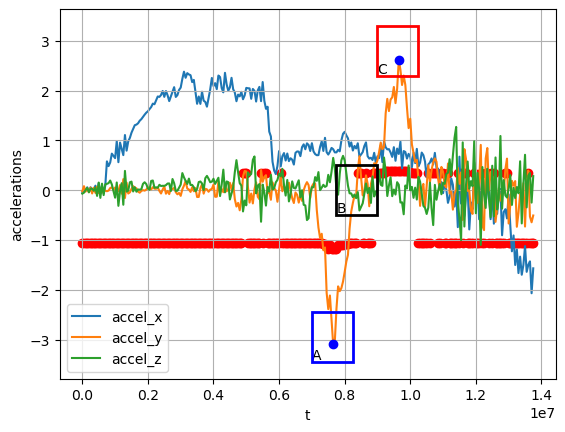

In [42]:
# Plot the accelerations but this time using the correct resolution of time and subtract by the first value to let the X values start at 0.
my_dict = dict(zip(df_lane_change.timestamp, df_lane_change.accel_y))

lst_timestamp_accelerations = []
for e in listOfEvents:
    firstTimeStamp_boxA = e[0][0] 
    firstTimeStamp_boxC = e[1][0] 
    
    lst_timestamp_accelerations.append({'timestamp': firstTimeStamp_boxA, 'accel_y': my_dict[firstTimeStamp_boxA]})
    lst_timestamp_accelerations.append({'timestamp': firstTimeStamp_boxC, 'accel_y': my_dict[firstTimeStamp_boxC]})

# dict_timestamp_accelerations contains now all pairs (timeStamp, accel_y) that match the query for the lane change.
dict_timestamp_accelerations = pd.DataFrame(lst_timestamp_accelerations, columns=['timestamp', 'accel_y'])

plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x", zorder=1)
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y", zorder=2)
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z", zorder=3)
plt.legend(loc="lower left")
plt.grid(True)

# Add illustrating rectangles around the areas of interest.
plt.text(0.7*1e7, -3.4, 'A')
lower = patches.Rectangle( (0.7*1e7, -3.45), 1.25e6, 1, linewidth=2, edgecolor="blue", facecolor='none', zorder=4)

plt.text(0.775*1e7, -.45, 'B')
middle = patches.Rectangle( (0.775*1e7, -.5), 1.25e6, 1, linewidth=2, edgecolor="black", facecolor='none', zorder=4)

plt.text(0.9*1e7, 2.35, 'C')
upper = patches.Rectangle( (0.9*1e7, 2.3), 1.25e6, 1, linewidth=2, edgecolor="red", facecolor='none', zorder=4)

plt.gca().add_patch(upper)
plt.gca().add_patch(middle)
plt.gca().add_patch(lower)

plt.scatter(df_lane_change_morton_scaled['timestamp'], df_lane_change_morton_scaled['morton'], color='red', zorder=0)

# Plot dict_timestamp_accelerations that match the query for the lane change.
plt.scatter(dict_timestamp_accelerations['timestamp'], dict_timestamp_accelerations['accel_y'], color='blue', zorder=5)

plt.show()

We see that the blue dots are located at the tips where we would expect them to denote a lane change maneuver.

As we have now all ingredients at hand, let's find more lane changes on a different file. First, we plot the content again.

Column headers: ['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds', 'lat', 'lon', 'speed', 'accel_x', 'accel_y', 'accel_z']


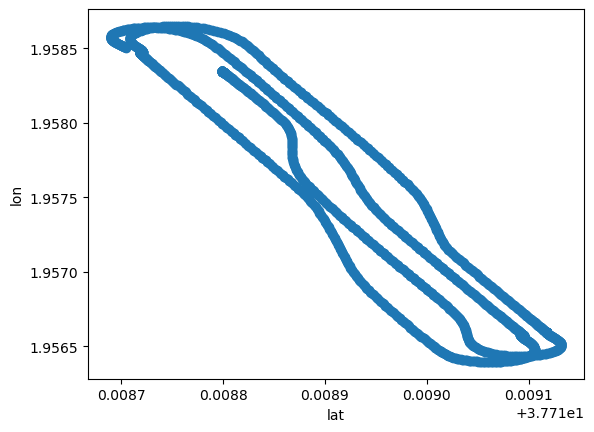

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# First, we read the CSV file.
df_lane_change = pd.read_csv('multiple_lane_changes.csv', sep=';')

# Next, we print the column headers to know what we have access to.
cols = df_lane_change.columns.values.tolist()
print( "Column headers: " + str(cols) )

# Plot the position of the vehicle using its speed to color.
plt.figure()
plt.xlabel('lat')
plt.ylabel('lon')
plt.scatter(df_lane_change['lat'], df_lane_change['lon'])
plt.show()

This dataset has four lane change maneuvers covered. Let's plot the accelerations over time but we ignore the Z-dimension.

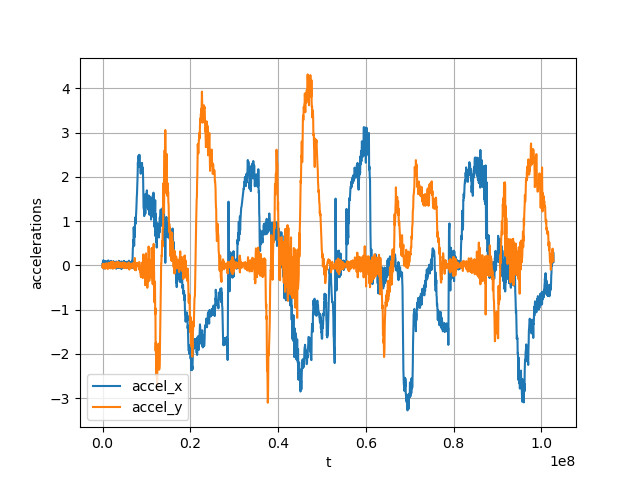

In [44]:
%matplotlib ipympl
from mplcursors import cursor
import matplotlib.patches as patches

# Plot the accelerations but this time using the correct resolution of time and subtract by the first value to let the X values start at 0.
offset = df_lane_change['sampleTimeStamp.seconds'][0] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'][0]
df_lane_change['timestamp'] = df_lane_change['sampleTimeStamp.seconds'] * 1000000 + df_lane_change['sampleTimeStamp.microseconds'] - offset

plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x")
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y")
#plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z")
plt.legend(loc="lower left")
plt.grid(True)
cursor(hover=True)

plt.show()

The temporal ranges as well as the Morton filters that we determined before do not work as expected and we need to heuristically adjust the values accordingly to make our filter work.

We will use the following thresholds:

In [45]:
# Heuristically determined.
area_a_lower = 8.9e5
area_a_upper = 9.1e5
area_c_lower = 2.44e6
area_c_upper = 2.6e6

# Heuristically determined; given in µs.
area_minimum_duration =  10000
area_maximum_duration = 400000

# Heuristically determined; given in µs.
minimum_event_duration = 1000000
maximum_event_duration = 5000000

In [46]:
counter = 0

lst = []
lst_morton_points = []
longitudinal_acceleration = 0.0
for _, row in df_lane_change.iterrows():
    # Compute the Morton value but keep the longitudinal acceleration const to 0.0
    morton = calculateMortonFromXYAccelerationFloats(longitudinal_acceleration, row['accel_y'])
    lst.append({'morton': morton, 'timestamp': row['timestamp']})

    # Scale the Morton values so that we can create an intuitive overlay plot.
    lst_morton_points.append({'timestamp': row['timestamp'], 'morton': (morton-2.1e6)/1e6})
    
    # Print raw Morton values.
    print( str(row['timestamp']) + ": (" + str(row['accel_x']) + "," + str(row['accel_y']) + ") --> " + str(morton) )
    counter = counter + 1

df_lane_change_morton = pd.DataFrame(lst, columns=['morton', 'timestamp'])

df_lane_change_morton_scaled = pd.DataFrame(lst_morton_points, columns=['morton', 'timestamp'])
print( df_lane_change_morton_scaled )

print( "Processed " + str(counter) + " rows." )

0.0: (0.0340612,-0.0367315) --> 1047648
49944.0: (-0.0543692,0.0265648) --> 1047752
99933.0: (0.101629,-0.0627829) --> 1047618
149979.0: (-0.0483371,0.0278948) --> 1047752
200049.0: (0.116677,-0.0490166) --> 1047626
249970.0: (-0.0476056,0.0239924) --> 1047752
300032.0: (0.0916287,-0.0228944) --> 1047650
349956.0: (-0.0733521,0.0375132) --> 1047754
399963.0: (0.0420668,0.0229241) --> 1047752
450161.0: (-0.0461468,0.0116645) --> 1047746
499955.0: (0.013979,0.0202412) --> 1047752
549970.0: (0.010659,-0.0168143) --> 1047656
600001.0: (0.00442924,0.000941013) --> 1047744
650006.0: (0.0664857,-0.0733816) --> 1047616
699972.0: (-0.0395075,0.0170305) --> 1047746
750054.0: (0.10129,-0.0610827) --> 1047618
800093.0: (-0.0572625,0.0492844) --> 1047776
849999.0: (0.080413,-0.00343432) --> 1047658
899983.0: (-0.0581026,0.034091) --> 1047754
949994.0: (0.0691199,0.0106708) --> 1047746
1000050.0: (-0.0381634,0.0191477) --> 1047746
1049986.0: (0.0159526,0.0100079) --> 1047746
1099959.0: (0.0248644,-0

Then, we filter by Morton ranges and search for matching temporal ranges:

In [47]:
my_dict = dict(zip(df_lane_change_morton.morton, df_lane_change_morton.timestamp))

area_a = list(filter( lambda k: k > area_a_lower and k < area_a_upper, my_dict.keys()) )
print( "Area A: " + str(area_a))

area_c = list(filter( lambda k: k > area_c_lower and k < area_c_upper, my_dict.keys()) )
print( "Area C: " + str(area_c))


# Turn list of Morton codes back to time points:
time_points_area_a = []
time_points_area_c = []

for a in area_a:
    time_points_area_a.append(my_dict[a])
for c in area_c:
    time_points_area_c.append(my_dict[c])

# Sort by time.
time_points_area_a = sorted( time_points_area_a )
time_points_area_c = sorted( time_points_area_c )

# This function returns a list of tuples (a, b) where (b-a) is the largest range within [minimum_duration, maximum_duration] from a list of timepoints:
def getRanges(listOfTimePoints, minDuration, maxDuration):
    assert len(listOfTimePoints) > 1, "listOfTimePoints must contain minimally two items"
    listOfTuples = []

    lastIdx = 0
    # Once a tuple has been added to the list of matching temporal ranges, start *after* the end point of the last tuple as long as there is more to process.
    while lastIdx < len(listOfTimePoints) and ((len(listOfTimePoints) - lastIdx) > 1):
        idx = lastIdx
        t1 = 0
        t2 = 0

        # Skip all time points that have been processed so far already (ie., slicing from idx:).
        for t in listOfTimePoints[idx:]:
            idx = idx + 1
            if t1 == 0:
                t1 = t
                continue
            # Check whether we find matching durations:
            if (t - t1) > minimum_duration and (t - t1) < maximum_duration:
                t2 = t
            # Stop criterion once we exceed the maximum duration:
            if (t - t1) > maximum_duration:
                break
        # Only add a tuple when we have valid start and end time points:
        if t1 > 0 and t2 > 0:
            listOfTuples.append( (t1, t2) )
            print( "Range " + str(len(listOfTuples)) + ": " + str(t1) + " --> " + str(t2) )
        lastIdx = idx
    return listOfTuples

ranges_a = getRanges(time_points_area_a, area_minimum_duration, area_maximum_duration)
print(str(ranges_a))

ranges_c = getRanges(time_points_area_c, area_minimum_duration, area_maximum_duration)
print(str(ranges_c))

Area A: [908872, 908992]
Area C: [2446400, 2446410, 2446920, 2446408, 2446570, 2447040, 2446912, 2447082, 2449096, 2449128, 2449120, 2456674, 2481224, 2457154, 2455272, 2479208, 2487490, 2489568, 2479306, 2577480, 2578114, 2490080, 2481730, 2479688, 2481386, 2487530, 2489418, 2481770, 2479202, 2479720, 2479714, 2479336, 2457186, 2457162, 2455234, 2449130, 2454626, 2448968, 2449122, 2448992, 2448482, 2447072, 2448970, 2448450, 2446528, 2448962, 2447080, 2446442, 2446530, 2448490, 2454760, 2455112, 2456770, 2457320, 2479168, 2481248, 2481738, 2489408, 2490050, 2489922, 2489448, 2489442, 2490048, 2577482, 2577602, 2577994, 2577514, 2579554, 2579658, 2580064, 2580200, 2580168, 2585794, 2580202, 2586186, 2588224, 2586218, 2585802, 2579656, 2580160, 2585698, 2586178, 2585832, 2585800, 2585826, 2585672, 2579648, 2578024, 2578146, 2577608, 2489930, 2579520, 2579682, 2579650, 2578122, 2577600, 2579530, 2577992, 2489962, 2489544, 2489952, 2490056, 2577640, 2489928, 2487874, 2481890, 2488008, 248

Then we filter by temporal ranges:

In [48]:
# Starting from the first list, we add elements from the other lists as long as R1 and R2 are fulfilled:
listOfEvents = []
for a in ranges_a:
    for c in ranges_c:
        # Check for t2 < t5
        if a[1] > c[0]:
            continue
        if ((c[1] - a[0]) > minimum_event_duration) and ((c[1] - a[0]) < maximum_event_duration):
            listOfEvents.append( (a, c) )
print( str(listOfEvents) )

[((37651215.0, 37701198.0), (39201298.0, 39401244.0)), ((37651215.0, 37701198.0), (39951296.0, 40101298.0))]


Finally, we plot the results:

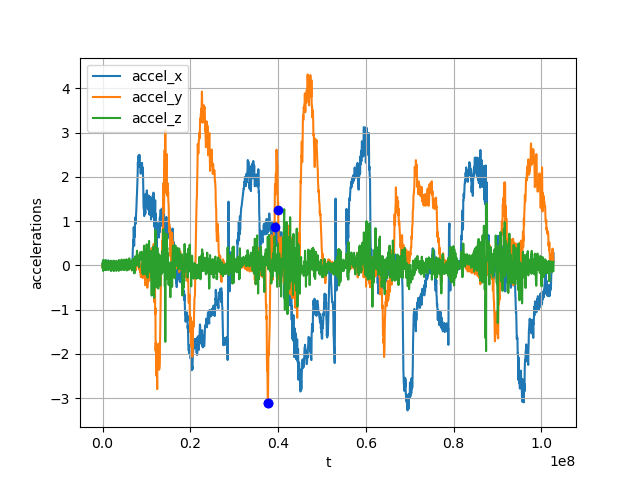

In [49]:
# Plot the accelerations but this time using the correct resolution of time and subtract by the first value to let the X values start at 0.
my_dict = dict(zip(df_lane_change.timestamp, df_lane_change.accel_y))

lst_timestamp_accelerations = []
for e in listOfEvents:
    firstTimeStamp_boxA = e[0][0] 
    firstTimeStamp_boxC = e[1][0] 
    
    lst_timestamp_accelerations.append({'timestamp': firstTimeStamp_boxA, 'accel_y': my_dict[firstTimeStamp_boxA]})
    lst_timestamp_accelerations.append({'timestamp': firstTimeStamp_boxC, 'accel_y': my_dict[firstTimeStamp_boxC]})

# dict_timestamp_accelerations contains now all pairs (timeStamp, accel_y) that match the query for the lane change.
dict_timestamp_accelerations = pd.DataFrame(lst_timestamp_accelerations, columns=['timestamp', 'accel_y'])

plt.figure()
plt.xlabel('t')
plt.ylabel('accelerations')
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_x'], label="accel_x", zorder=1)
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_y'], label="accel_y", zorder=2)
plt.plot(df_lane_change['timestamp'], df_lane_change['accel_z'], label="accel_z", zorder=3)
plt.legend(loc="upper left")
plt.grid(True)

# Plot dict_timestamp_accelerations that match the query for the lane change.
plt.scatter(dict_timestamp_accelerations['timestamp'], dict_timestamp_accelerations['accel_y'], color='blue', zorder=5)

plt.show()

The filter worked but could only find one lane change event after heuristically adjusting the threshold values. Hence, as a next step, we need to systematically determine the Morton values along the y-axis to better determine the threshold values that we are interested in.

Therefore, we systematically create a plot that shows on the X-axis possible acceleration values from -1g to +1g and on the Y-axis the corresponding Morton codes:

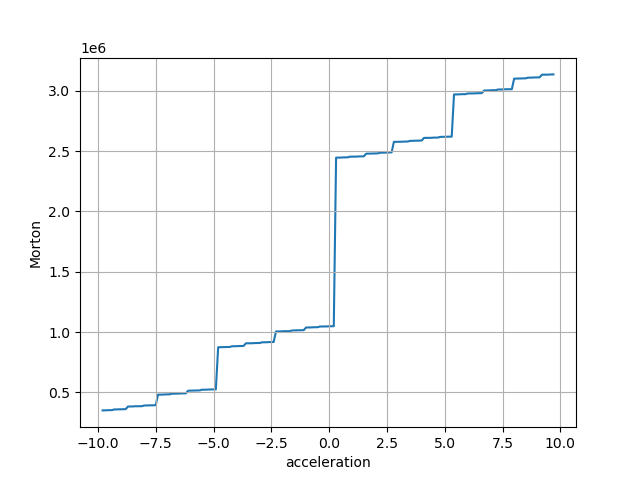

In [50]:
%matplotlib ipympl
from mplcursors import cursor

# Create a list of accelerations from -1g to +1g in 0.1 resolution:
longitudinal_acceleration = 0.0
lst_accelerations_vs_morton = []
for x in range(-98, +98, 1):
    a = x/10.0
    morton = calculateMortonFromXYAccelerationFloats(longitudinal_acceleration, a)
    lst_accelerations_vs_morton.append({'acceleration': a, 'morton': morton})

df_accelerations_vs_morton = pd.DataFrame(lst_accelerations_vs_morton, columns=['acceleration', 'morton'])

plt.figure()
plt.xlabel('acceleration')
plt.ylabel('Morton')
plt.plot(df_accelerations_vs_morton['acceleration'], df_accelerations_vs_morton['morton'], zorder=1)
plt.grid(True)
cursor(hover=True)
plt.show()